## 군집분석
P. 525 부터

## 회귀분석 예제 : 부동산 가격 예측

### 목적 : 다른 변수들을 사용해 medv (주택 가격) 을 예측하는 것!

- crim : 범죄 발생률
- zn : 주거지 중 25000 $ft^2$ 이상 크기의 대형주택이 차지하는 비율
- indus : 소매상 이외의 상업지구의 면적 비율
- chas : 찰스강과 접한 지역은 1, 아니면 0 인 더미변수
- nox : 산화질소 오염도
- rm : 주거지당 평균 방 개수
- age : 소유자 주거비 중 1940년 이전에 지어진 집들의 비율
- dis : 보스턴의 5대 고용중심으로부터의 가중 평균 거리
- rad : 도시 순환 고속도로에의 접근 용이 지수
- tax : 만달러당 주택 재산세율
- ptratio : 학생-선생 비율
- black : 흑인 인구 비율(Bk) 이 0.63과 다른 정도의 제곱
- lstat : 저소득 주민들의 비율 퍼센트
- medv : 소유자 주거지 주택 가격

In [1]:
library(dplyr)
library(ggplot2)
library(MASS)
library(glmnet)
library(randomForest)
library(gbm)
library(rpart)
library(boot)
library(data.table)
library(ROCR)
library(gridExtra)

Warning message:
"package 'dplyr' was built under R version 3.4.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.4.2"
Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Warning message:
"package 'glmnet' was built under R version 3.4.2"Loading required package: Matrix
Loading required package: foreach
Warning message:
"package 'foreach' was built under R version 3.4.2"Loaded glmnet 2.0-13

Warning message:
"package 'randomForest' was built under R version 3.4.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'gbm' w

In [29]:
rmse <- function(yi, yhat_i) {
    sqrt(mean((yi - yhat_i) ^ 2))
}

In [38]:
mae <- function(yi, yhat_i) {
    mean(abs(yi - yhat_i))
}

In [36]:
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...) {
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- abs(cor(x, y))
    txt <- format(c(r, 0.123456789), digits = digits)[1]
    txt <- paste0(prefix, txt)
    
    if(missing(cex.cor)) cex.cor <- 0.8/strwidth(txt)
        text(0.5, 0.5, txt, cex = cex.cor * r)
}

In [3]:
# 데이터셋 다운로드
curl http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data > housing.data
curl http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names > housing.names

ERROR: Error in parse(text = x, srcfile = src): <text>:2:6: 예상하지 못한 기호(symbol)입니다.
1: # 데이터셋 다운로드
2: curl http
        ^


In [4]:
data <- tbl_df(read.table("data/housing.data", strip.white = TRUE))

In [5]:
names(data) <- c('crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
                 'tax', 'ptratio', 'b', 'lstat', 'medv')

In [6]:
glimpse(data)

Observations: 506
Variables: 14
$ crim    <dbl> 0.00632, 0.02731, 0.02729, 0.03237, 0.06905, 0.02985, 0.088...
$ zn      <dbl> 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 12.5, 12.5, 12.5, 12.5...
$ indus   <dbl> 2.31, 7.07, 7.07, 2.18, 2.18, 2.18, 7.87, 7.87, 7.87, 7.87,...
$ chas    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ nox     <dbl> 0.538, 0.469, 0.469, 0.458, 0.458, 0.458, 0.524, 0.524, 0.5...
$ rm      <dbl> 6.575, 6.421, 7.185, 6.998, 7.147, 6.430, 6.012, 6.172, 5.6...
$ age     <dbl> 65.2, 78.9, 61.1, 45.8, 54.2, 58.7, 66.6, 96.1, 100.0, 85.9...
$ dis     <dbl> 4.0900, 4.9671, 4.9671, 6.0622, 6.0622, 6.0622, 5.5605, 5.9...
$ rad     <int> 1, 2, 2, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,...
$ tax     <dbl> 296, 242, 242, 222, 222, 222, 311, 311, 311, 311, 311, 311,...
$ ptratio <dbl> 15.3, 17.8, 17.8, 18.7, 18.7, 18.7, 15.2, 15.2, 15.2, 15.2,...
$ b       <dbl> 396.90, 396.90, 392.83, 394.63, 396.90, 394.12, 395.60, 396...
$ lstat   <dbl> 4.98

In [7]:
summary(data)

      crim                zn             indus            chas        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   Min.   :0.00000  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1st Qu.:0.00000  
 Median : 0.25651   Median :  0.00   Median : 9.69   Median :0.00000  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14   Mean   :0.06917  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10   3rd Qu.:0.00000  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74   Max.   :1.00000  
      nox               rm             age              dis        
 Min.   :0.3850   Min.   :3.561   Min.   :  2.90   Min.   : 1.130  
 1st Qu.:0.4490   1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100  
 Median :0.5380   Median :6.208   Median : 77.50   Median : 3.207  
 Mean   :0.5547   Mean   :6.285   Mean   : 68.57   Mean   : 3.795  
 3rd Qu.:0.6240   3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188  
 Max.   :0.8710   Max.   :8.780   Max.   :100.00   Max.   :12.127  
      rad              tax 

모든 $x, y$ 변수들 간의 산점도를 그려보자

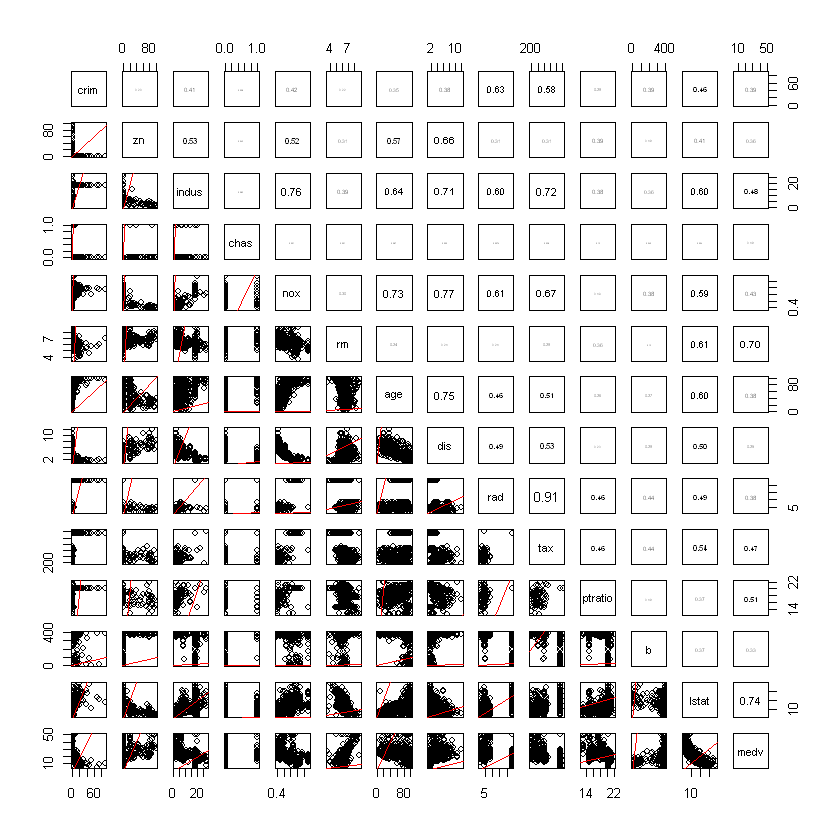

In [37]:
pairs(data %>% sample_n(min(1000, nrow(data))),
     lower.panel = function(x, y) { points(x, y); abline(0, 1, col = 'red' )},
     upper.panel = panel.cor)

In [14]:
set.seed(1606)
n <- nrow(data)
idx <- 1:n

In [15]:
training_idx <- sample(idx, n * .60)
idx <- setdiff(idx, training_idx)
validate_idx <- sample(idx, n * .20)
test_idx <- setdiff(idx, validate_idx)
training <- data[training_idx, ]
validation <- data[validate_idx, ]
test <- data[test_idx, ]

**선형회귀 모형**



In [17]:
data_lm_full <- lm(medv ~ ., data = training)
summary(data_lm_full)


Call:
lm(formula = medv ~ ., data = training)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.4052  -2.7972  -0.5562   1.6095  25.8817 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  38.482205   6.981702   5.512 7.87e-08 ***
crim         -0.083843   0.049729  -1.686  0.09288 .  
zn            0.052513   0.018433   2.849  0.00470 ** 
indus        -0.045224   0.083642  -0.541  0.58914    
chas          2.269883   1.263521   1.796  0.07346 .  
nox         -15.244278   5.051438  -3.018  0.00277 ** 
rm            3.150088   0.587849   5.359 1.72e-07 ***
age          -0.015211   0.018037  -0.843  0.39975    
dis          -1.589551   0.277367  -5.731 2.51e-08 ***
rad           0.273142   0.090072   3.032  0.00265 ** 
tax          -0.010767   0.005002  -2.152  0.03220 *  
ptratio      -0.838938   0.181722  -4.617 5.88e-06 ***
b             0.009781   0.003699   2.644  0.00864 ** 
lstat        -0.504131   0.068753  -7.332 2.28e-12 ***
---
Signi

예측력이 강한 변수들
- lstat
- rm
- ptratio
- dis

In [18]:
predict(data_lm_full, newdata = data[1:5, ])

1        2        3        4        5 
29.96183 24.42376 29.63748 28.22937 27.38522

In [19]:
# 포뮬라 인터페이스를 사용하여 쉽게 이차상호작용 모형을 적합
data_lm_full_2 <- lm(medv ~ .^2, data = training)
summary(data_lm_full_2)


Call:
lm(formula = medv ~ .^2, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1272 -1.4447 -0.1633  1.3138 16.5580 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.945e+02  9.576e+01  -2.031 0.043480 *  
crim          -1.788e+01  9.440e+00  -1.894 0.059538 .  
zn             3.490e-01  6.560e-01   0.532 0.595243    
indus         -9.258e-01  2.381e+00  -0.389 0.697781    
chas           3.014e+01  4.731e+01   0.637 0.524837    
nox            8.549e+01  1.066e+02   0.802 0.423312    
rm             3.519e+01  9.482e+00   3.711 0.000264 ***
age            1.157e+00  4.046e-01   2.860 0.004665 ** 
dis           -4.101e+00  7.057e+00  -0.581 0.561758    
rad            4.175e+00  4.154e+00   1.005 0.315984    
tax           -7.380e-02  2.184e-01  -0.338 0.735792    
ptratio        2.498e+00  4.161e+00   0.600 0.548975    
b              8.090e-02  8.938e-02   0.905 0.366400    
lstat          2.671e+00  1.286e+00   2.076 

summary() 결과 대부분의 변수는 통계적으로 유의하지 않다.

stepwise 변수 선택으로 선형회귀 모형에서 중요한 변수를 자동으로 선택해준다.

In [20]:
data_step <- stepAIC(data_lm_full,
                    scope = list(upper = ~ .^2, lower = ~1))

Start:  AIC=995.9
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat

                Df Sum of Sq    RSS     AIC
+ rm:lstat       1   1679.28 5712.5  919.82
+ rm:tax         1   1631.10 5760.7  922.36
+ indus:rm       1   1617.25 5774.6  923.09
+ rm:rad         1   1399.25 5992.6  934.32
+ rm:dis         1   1108.04 6283.8  948.69
+ nox:rm         1   1063.09 6328.7  950.85
+ rm:age         1   1034.78 6357.0  952.21
+ rm:ptratio     1    894.70 6497.1  958.81
+ crim:rm        1    842.78 6549.0  961.22
+ crim:chas      1    663.67 6728.1  969.40
+ rm:b           1    609.50 6782.3  971.83
+ indus:dis      1    564.72 6827.1  973.82
+ zn:rm          1    533.64 6858.2  975.20
+ crim:nox       1    306.37 7085.5  985.08
+ chas:rad       1    270.63 7121.2  986.60
+ zn:indus       1    246.00 7145.8  987.65
+ age:dis        1    243.35 7148.5  987.76
+ chas:ptratio   1    243.25 7148.6  987.76
+ chas:tax       1    242.17 7149.7  987.81
+ crim:


Step:  AIC=894.76
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas

                Df Sum of Sq    RSS    AIC
+ rm:tax         1    576.38 4648.2 861.35
+ rm:rad         1    518.67 4706.0 865.08
+ indus:rm       1    469.88 4754.7 868.21
+ chas:tax       1    404.07 4820.5 872.37
+ rm:ptratio     1    397.74 4826.9 872.77
+ chas:rm        1    313.20 4911.4 878.03
+ chas:nox       1    284.36 4940.3 879.81
+ rm:dis         1    272.91 4951.7 880.51
+ rad:lstat      1    262.40 4962.2 881.15
+ tax:lstat      1    228.53 4996.1 883.21
+ nox:rm         1    223.80 5000.8 883.50
+ zn:rm          1    222.44 5002.2 883.58
+ rm:age         1    220.32 5004.3 883.71
+ chas:rad       1    185.28 5039.3 885.82
+ chas:dis       1    159.53 5065.1 887.37
+ crim:nox       1    158.37 5066.3 887.44
+ indus:dis      1    148.95 5075.7 888.00
+ zn:indus       1    144.61 5080.0 888.26
+ indus:chas     1    141.48 5083.1 888.45
+ c


Step:  AIC=792.6
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis

                Df Sum of Sq    RSS    AIC
+ age:b          1    223.09 3433.1 775.53
+ b:lstat        1    216.42 3439.7 776.11
+ chas:nox       1    167.31 3488.9 780.41
+ chas:rm        1    143.50 3512.7 782.47
+ chas:tax       1    114.26 3541.9 784.98
+ age:tax        1    113.96 3542.2 785.01
+ age:rad        1     98.01 3558.2 786.37
+ chas:dis       1     76.73 3579.4 788.18
+ dis:tax        1     75.03 3581.1 788.32
+ dis:b          1     74.19 3582.0 788.39
+ indus:lstat    1     73.46 3582.7 788.45
+ crim:b         1     64.98 3591.2 789.17
+ dis:rad        1     63.17 3593.0 789.32
+ crim:age       1     62.07 3594.1 789.41
+ crim:rm        1     59.32 3596.8 789.65
+ crim:nox       1     50.69 3605.5 790.37
+ indus:tax      1     49.38 3606.8 790.48
+ zn:rm          1     43.94 3612.2 790.94
- zn     


Step:  AIC=746.67
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis + age:b + chas:nox + chas:rm

                Df Sum of Sq    RSS    AIC
+ indus:lstat    1    113.34 2967.0 737.31
+ b:lstat        1     91.63 2988.7 739.52
+ dis:tax        1     87.68 2992.6 739.92
+ dis:rad        1     70.44 3009.9 741.66
+ age:lstat      1     59.85 3020.5 742.73
+ indus:rm       1     59.49 3020.8 742.76
+ indus:tax      1     57.82 3022.5 742.93
+ dis:lstat      1     57.02 3023.3 743.01
+ crim:nox       1     56.18 3024.1 743.10
+ tax:ptratio    1     49.75 3030.6 743.74
+ age:tax        1     40.91 3039.4 744.62
+ crim:rm        1     39.69 3040.6 744.74
+ rm:ptratio     1     33.54 3046.8 745.36
+ nox:lstat      1     33.50 3046.8 745.36
+ zn:rm          1     32.70 3047.6 745.44
+ indus:nox      1     28.90 3051.4 745.82
+ crim:b         1     26.88 3053.4 746.02
- zn             1    


Step:  AIC=717.52
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis + age:b + chas:nox + chas:rm + indus:lstat + 
    b:lstat + crim:rm

                Df Sum of Sq    RSS    AIC
+ tax:ptratio    1     67.38 2675.6 711.99
+ indus:tax      1     45.33 2697.6 714.48
+ dis:tax        1     45.05 2697.9 714.51
+ zn:rm          1     42.22 2700.7 714.82
+ age:tax        1     40.04 2702.9 715.07
+ dis:rad        1     39.95 2703.0 715.08
+ age:rad        1     34.68 2708.3 715.67
+ crim:lstat     1     32.53 2710.4 715.91
+ rm:ptratio     1     26.93 2716.0 716.53
+ rad:lstat      1     25.62 2717.3 716.68
- zn             1     10.62 2753.6 716.69
+ rm:b           1     23.06 2719.9 716.97
+ crim:nox       1     22.79 2720.1 717.00
+ zn:lstat       1     19.33 2723.6 717.38
<none>                       2742.9 717.52
+ zn:indus       1     16.15 2726.8 717.74
+ zn:rad         1     15.


Step:  AIC=700.52
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis + age:b + chas:nox + chas:rm + indus:lstat + 
    b:lstat + crim:rm + tax:ptratio + indus:ptratio + zn:rm

                Df Sum of Sq    RSS    AIC
+ crim:lstat     1     43.12 2499.2 697.33
+ dis:rad        1     31.38 2511.0 698.75
+ age:rad        1     28.81 2513.5 699.06
+ nox:tax        1     26.14 2516.2 699.38
+ rm:ptratio     1     25.85 2516.5 699.42
+ rm:b           1     24.73 2517.6 699.55
+ crim:nox       1     20.86 2521.5 700.02
+ zn:tax         1     20.20 2522.1 700.10
+ indus:nox      1     18.93 2523.4 700.25
<none>                       2542.4 700.52
+ crim:age       1     15.41 2526.9 700.67
+ zn:rad         1     14.75 2527.6 700.75
+ nox:rad        1     13.69 2528.7 700.88
+ crim:dis       1     12.61 2529.7 701.01
+ nox:b          1     11.32 2531.0 701.16
+ chas:dis       1     10.60 25


Step:  AIC=687.42
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis + age:b + chas:nox + chas:rm + indus:lstat + 
    b:lstat + crim:rm + tax:ptratio + indus:ptratio + zn:rm + 
    crim:lstat + crim:nox + age:rad

                Df Sum of Sq    RSS    AIC
+ rm:b           1     37.96 2349.1 684.56
+ nox:age        1     28.17 2358.9 685.82
+ rad:lstat      1     26.95 2360.1 685.97
+ rm:ptratio     1     22.82 2364.2 686.50
+ rad:tax        1     17.15 2369.9 687.23
<none>                       2387.0 687.42
+ zn:tax         1     14.63 2372.4 687.55
+ age:lstat      1     13.84 2373.2 687.65
+ dis:lstat      1     11.44 2375.6 687.96
+ nox:rad        1      9.36 2377.7 688.23
+ nox:dis        1      9.33 2377.7 688.23
+ indus:rm       1      8.44 2378.6 688.34
+ nox:tax        1      8.22 2378.8 688.37
+ crim:rad       1      7.08 2380.0 688.51
+ crim:dis       1      6.90 2380.1


Step:  AIC=678.8
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    tax:lstat + indus:dis + age:b + chas:nox + chas:rm + indus:lstat + 
    b:lstat + crim:rm + tax:ptratio + indus:ptratio + zn:rm + 
    crim:lstat + crim:nox + age:rad + rm:b + rad:lstat + rm:rad

                Df Sum of Sq    RSS    AIC
+ age:tax        1     34.13 2240.5 676.22
+ nox:age        1     31.87 2242.8 676.53
+ zn:tax         1     26.74 2247.9 677.22
+ age:lstat      1     19.68 2255.0 678.17
+ rm:ptratio     1     17.77 2256.9 678.42
<none>                       2274.6 678.80
+ dis:rad        1     14.30 2260.3 678.89
+ rad:tax        1     12.32 2262.3 679.16
+ dis:lstat      1     12.24 2262.4 679.17
+ nox:tax        1     11.47 2263.2 679.27
+ dis:b          1      7.87 2266.8 679.75
+ crim:b         1      7.37 2267.3 679.82
+ rad:ptratio    1      6.71 2267.9 679.90
+ nox:dis        1      6.70 2267.9 679.91
+ zn:ptr


Step:  AIC=672.88
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + rm:tax + 
    indus:dis + age:b + chas:nox + chas:rm + indus:lstat + b:lstat + 
    crim:rm + tax:ptratio + indus:ptratio + zn:rm + crim:lstat + 
    crim:nox + age:rad + rm:b + rad:lstat + rm:rad + age:tax + 
    rad:tax

                Df Sum of Sq    RSS    AIC
+ nox:age        1     22.58 2193.4 671.78
+ dis:lstat      1     21.01 2194.9 672.00
+ age:lstat      1     16.54 2199.4 672.61
+ dis:rad        1     15.79 2200.2 672.71
- rm:tax         1     14.07 2230.0 672.80
+ indus:tax      1     15.16 2200.8 672.80
<none>                       2216.0 672.88
+ nox:dis        1     13.03 2202.9 673.09
+ indus:rad      1     11.61 2204.3 673.29
+ rm:age         1     10.74 2205.2 673.41
+ zn:rad         1      9.65 2206.3 673.56
+ chas:dis       1      8.56 2207.4 673.71
+ crim:indus     1      7.61 2208.3 673.84
+ crim:b         1      6.69 2209.3 6


Step:  AIC=670.73
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + indus:dis + 
    age:b + chas:nox + chas:rm + indus:lstat + b:lstat + crim:rm + 
    tax:ptratio + indus:ptratio + zn:rm + crim:lstat + crim:nox + 
    age:rad + rm:b + rad:lstat + rm:rad + age:tax + rad:tax + 
    nox:age + indus:tax

                Df Sum of Sq    RSS    AIC
+ rm:age         1     20.11 2165.7 669.93
+ dis:rad        1     17.91 2167.9 670.24
<none>                       2185.8 670.73
+ dis:lstat      1     10.72 2175.1 671.24
- indus:tax      1     20.16 2206.0 671.51
+ chas:dis       1      8.74 2177.1 671.52
+ zn:age         1      7.90 2177.9 671.63
+ crim:indus     1      7.71 2178.1 671.66
+ age:dis        1      7.32 2178.5 671.71
+ zn:rad         1      7.21 2178.6 671.73
- nox:age        1     21.83 2207.7 671.74
+ indus:rad      1      6.66 2179.2 671.81
+ crim:rad       1      6.49 2179.3 671.83
+ rm:ptratio     1      


Step:  AIC=665.03
medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + b + lstat + rm:lstat + crim:chas + indus:dis + 
    age:b + chas:nox + chas:rm + indus:lstat + b:lstat + crim:rm + 
    tax:ptratio + indus:ptratio + zn:rm + crim:lstat + crim:nox + 
    age:rad + rm:b + rad:lstat + rm:rad + age:tax + rad:tax + 
    nox:age + indus:tax + rm:age + age:lstat + rm:ptratio

                Df Sum of Sq    RSS    AIC
- zn:rm          1      6.42 2109.4 663.95
- nox:age        1      8.08 2111.1 664.19
+ dis:rad        1     17.45 2085.5 664.50
<none>                       2103.0 665.03
+ zn:lstat       1     13.36 2089.6 665.09
+ crim:rad       1     10.87 2092.1 665.46
+ rad:ptratio    1     10.43 2092.6 665.52
+ zn:age         1      9.25 2093.7 665.69
+ age:dis        1      8.44 2094.6 665.81
+ dis:lstat      1      8.08 2094.9 665.86
+ chas:dis       1      6.79 2096.2 666.05
+ crim:ptratio   1      6.71 2096.3 666.06
+ crim:b         1      6.33 2096


Step:  AIC=662.3
medv ~ crim + indus + chas + nox + rm + age + dis + rad + tax + 
    ptratio + b + lstat + rm:lstat + crim:chas + indus:dis + 
    age:b + chas:nox + chas:rm + indus:lstat + b:lstat + crim:rm + 
    tax:ptratio + indus:ptratio + crim:lstat + crim:nox + age:rad + 
    rm:b + rad:lstat + rm:rad + age:tax + rad:tax + nox:age + 
    indus:tax + rm:age + age:lstat + rm:ptratio + dis:rad

                Df Sum of Sq    RSS    AIC
- nox:age        1      9.77 2107.7 661.71
<none>                       2097.9 662.30
+ crim:rad       1     13.49 2084.4 662.34
+ rad:ptratio    1     11.52 2086.4 662.63
+ crim:ptratio   1     10.49 2087.4 662.78
- dis:rad        1     17.40 2115.3 662.80
+ age:dis        1      9.20 2088.7 662.97
+ nox:rad        1      9.10 2088.8 662.98
+ crim:b         1      8.39 2089.6 663.09
+ crim:tax       1      7.71 2090.2 663.18
+ age:ptratio    1      6.50 2091.4 663.36
+ nox:rm         1      5.99 2092.0 663.43
+ chas:dis       1      5.84 2092.1 6

In [21]:
length(coef(data_step))

[1] 37

### 모형 평가

In [22]:
y_obs <- validation$medv
yhat_lm <- predict(data_lm_full, newdata = validation)
yhat_lm_2 <- predict(data_lm_full_2, newdata = validation)
yhat_step <- predict(data_step, newdata = validation)

In [28]:
library(Metric)

ERROR: Error in library(Metric): there is no package called 'Metric'


In [31]:
rmse(y_obs, yhat_lm)
rmse(y_obs, yhat_lm_2)
rmse(y_obs, yhat_step)

[1] 4.619052

[1] 4.257667

[1] 3.839083

### 라쏘 모형 적합

In [32]:
xx <- model.matrix(medv ~ .^2-1, data)
x <- xx[training_idx, ]
y <- training$medv
glimpse(x)

 num [1:303, 1:91] 0.6635 3.6931 4.5419 3.8497 0.0871 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:303] "259" "462" "361" "358" ...
  ..$ : chr [1:91] "crim" "zn" "indus" "chas" ...


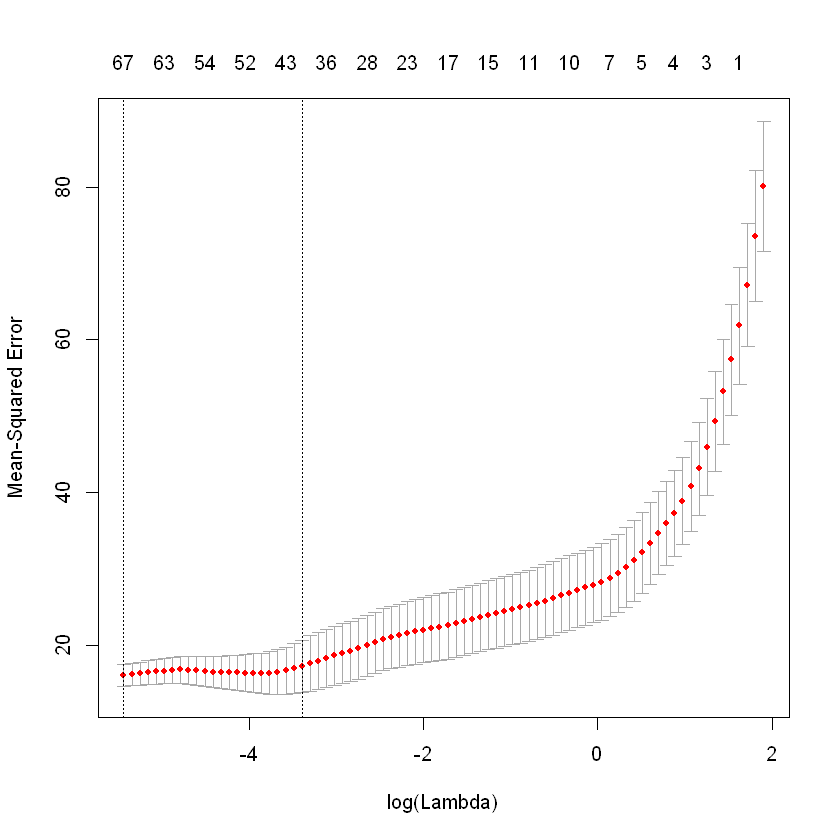

In [39]:
data_cvfit <- cv.glmnet(x, y)
plot(data_cvfit)

In [41]:
coef(data_cvfit, s = c("lambda.1se"))
coef(data_cvfit, s = c("lambda.min"))

92 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)   -1.822618e+01
crim           .           
zn             .           
indus          1.393884e-01
chas           .           
nox            .           
rm             1.215634e+01
age            .           
dis           -3.280315e-01
rad            6.156128e-01
tax            7.076958e-03
ptratio        .           
b              .           
lstat          1.010658e+00
crim:zn        5.385147e-02
crim:indus     .           
crim:chas      4.595143e+00
crim:nox       .           
crim:rm        .           
crim:age       .           
crim:dis      -4.700718e-02
crim:rad       .           
crim:tax       .           
crim:ptratio   .           
crim:b        -3.864892e-04
crim:lstat     .           
zn:indus      -5.754624e-03
zn:chas       -5.707990e-02
zn:nox         .           
zn:rm          6.482113e-03
zn:age         .           
zn:dis         .           
zn:rad        -1.586058e-03
zn:tax

92 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)   -8.250705e+01
crim           .           
zn            -1.392188e-01
indus          1.802028e-02
chas           1.252711e+01
nox            4.914097e+00
rm             2.346724e+01
age            4.160420e-01
dis           -3.024584e+00
rad            1.612689e+00
tax            .           
ptratio        .           
b              1.953851e-02
lstat          1.786527e+00
crim:zn       -2.758939e-02
crim:indus     .           
crim:chas      3.897067e+00
crim:nox      -1.137391e+00
crim:rm        1.614326e-01
crim:age       .           
crim:dis      -1.501727e-01
crim:rad      -1.578869e-02
crim:tax       .           
crim:ptratio   .           
crim:b        -4.372032e-04
crim:lstat     1.740295e-02
zn:indus      -3.272924e-03
zn:chas       -5.552781e-02
zn:nox         .           
zn:rm          .           
zn:age         4.733237e-04
zn:dis         4.400455e-03
zn:rad        -4.701290e-03
zn:tax

In [42]:
predict.cv.glmnet(data_cvfit, s = "lambda.min", newx = x[1:5, ])

,1
259,36.66366
462,19.36986
361,25.20614
358,22.05094
78,21.61332


다섯 관측값에 대한 예측값을 계산해주었다.

In [43]:
y_obs <- validation$medv
yhat_glmnet <- predict(data_cvfit, s = "lambda.min", newx = xx[validate_idx, ])
yhat_glmnet <- yhat_glmnet[, 1]
rmse(y_obs, yhat_glmnet)

[1] 3.956797

앞서 stepwise 변수 선택을 해준 선형 모형 (RMSE = 3.84) 에 비해 조금 약한 예측력을 보여준다.

In [44]:
data_tr <- rpart(medv ~ ., data = training)
data_tr

n= 303 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 303 24456.5000 22.41782  
   2) lstat>=9.54 184  4745.3400 17.56467  
     4) lstat>=16.085 89  1645.4800 14.17640  
       8) nox>=0.603 55   666.7571 12.20727  
        16) crim>=9.87002 20   121.7775  9.02500 *
        17) crim< 9.87002 35   226.7069 14.02571 *
       9) nox< 0.603 34   420.4803 17.36176 *
     5) lstat< 16.085 95  1120.8860 20.73895 *
   3) lstat< 9.54 119  8676.4630 29.92185  
     6) lstat>=4.23 96  3905.7240 27.22188  
      12) rm< 6.775 66  1845.8240 24.81970  
        24) age< 82.65 59   448.7668 23.87627 *
        25) age>=82.65 7   901.9343 32.77143 *
      13) rm>=6.775 30   841.1787 32.50667  
        26) tax>=264.5 18   300.2000 29.76667 *
        27) tax< 264.5 12   203.1367 36.61667 *
     7) lstat< 4.23 23  1149.8980 41.19130  
      14) rm< 7.3705 10   536.0890 36.19000 *
      15) rm>=7.3705 13   171.2708 45.03846 *

In [45]:
printcp(data_tr)


Regression tree:
rpart(formula = medv ~ ., data = training)

Variables actually used in tree construction:
[1] age   crim  lstat nox   rm    tax  

Root node error: 24457/303 = 80.715

n= 303 

         CP nsplit rel error  xerror     xstd
1  0.451197      0   1.00000 1.00536 0.105850
2  0.148052      1   0.54880 0.60714 0.074334
3  0.080918      2   0.40075 0.47107 0.067398
4  0.049832      3   0.31983 0.39691 0.062617
5  0.022826      4   0.27000 0.35143 0.057442
6  0.020245      5   0.24717 0.33970 0.049522
7  0.018095      6   0.22693 0.32404 0.049354
8  0.013814      7   0.20883 0.32139 0.049362
9  0.013014      8   0.19502 0.31773 0.049237
10 0.010000      9   0.18201 0.31716 0.049495


In [46]:
summary(data_tr)

Call:
rpart(formula = medv ~ ., data = training)
  n= 303 

           CP nsplit rel error    xerror       xstd
1  0.45119696      0 1.0000000 1.0053578 0.10585043
2  0.14805227      1 0.5488030 0.6071360 0.07433439
3  0.08091811      2 0.4007508 0.4710667 0.06739762
4  0.04983218      3 0.3198327 0.3969096 0.06261674
5  0.02282596      4 0.2700005 0.3514276 0.05744205
6  0.02024506      5 0.2471745 0.3397043 0.04952248
7  0.01809492      6 0.2269295 0.3240446 0.04935428
8  0.01381399      7 0.2088345 0.3213892 0.04936242
9  0.01301383      8 0.1950205 0.3177309 0.04923672
10 0.01000000      9 0.1820067 0.3171581 0.04949540

Variable importance
  lstat   indus      rm     nox     age    crim     dis     tax ptratio 
     29      14      14      13      12      11       3       3       1 

Node number 1: 303 observations,    complexity param=0.451197
  mean=22.41782, MSE=80.71453 
  left son=2 (184 obs) right son=3 (119 obs)
  Primary splits:
      lstat   < 9.54     to the right, impro

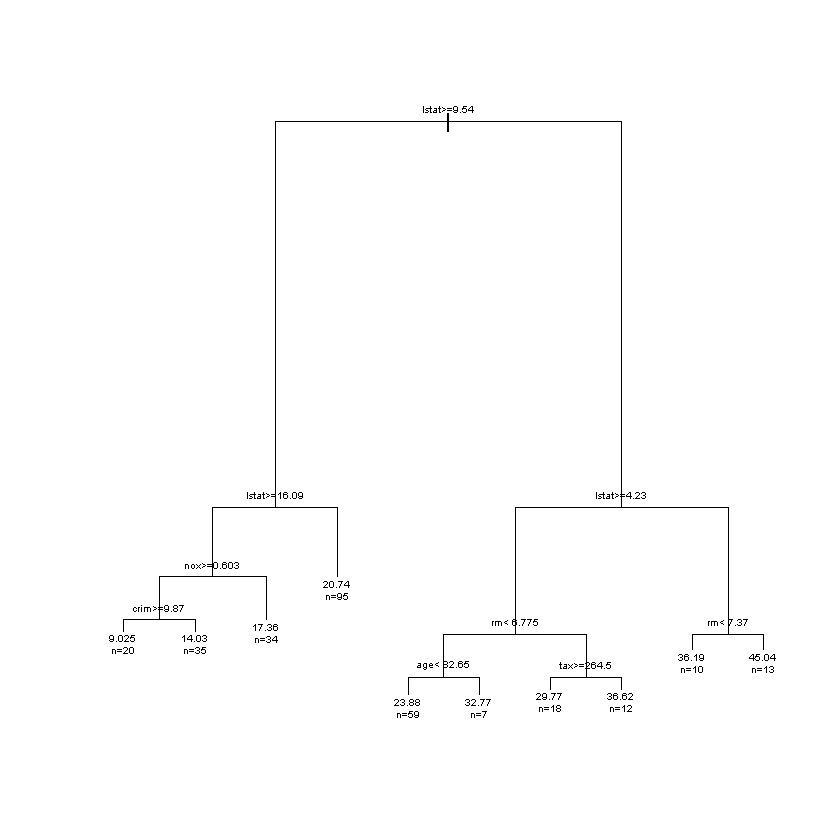

In [49]:
plot(data_tr)
text(data_tr, use.n = TRUE, cex = 0.5)

In [50]:
yhat_tr <- predict(data_tr, validation)
rmse(y_obs, yhat_tr)

[1] 4.756022

### 랜덤 포레스트

In [51]:
set.seed(1607)
data_rf <- randomForest(medv ~ ., training)
data_rf


Call:
 randomForest(formula = medv ~ ., data = training) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 12.88037
                    % Var explained: 84.04

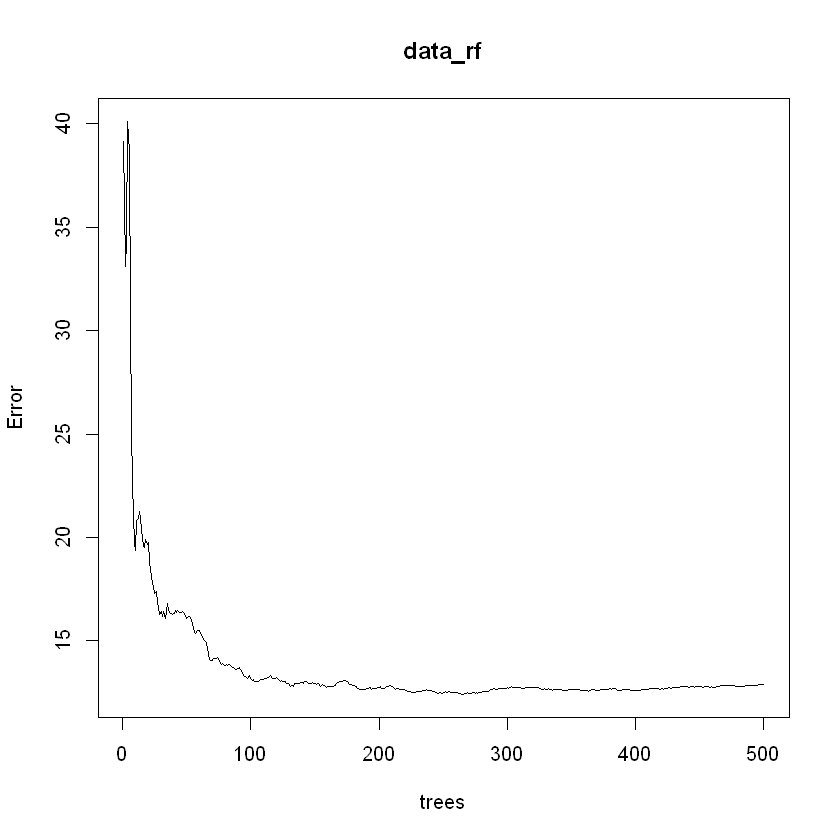

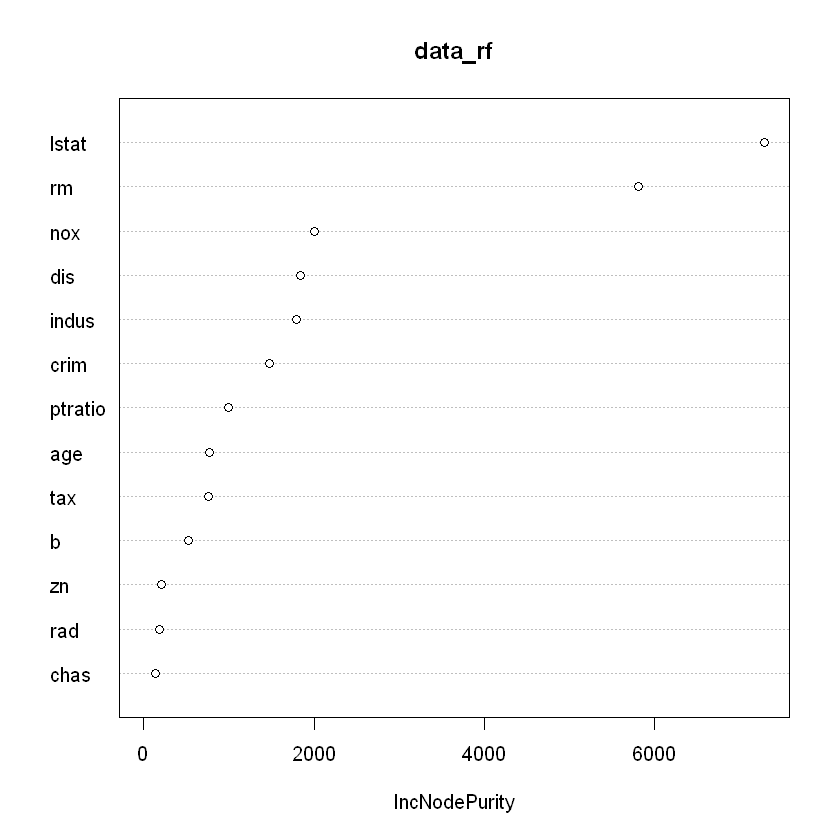

In [54]:
plot(data_rf)
varImpPlot(data_rf)

In [55]:
yhat_rf <- predict(data_rf, newdata = validation)
rmse(y_obs, yhat_rf)

[1] 3.548442

In [56]:
set.seed(1607)
data_gbm <- gbm(medv ~ ., data = training,
               n.trees = 40000, cv.folds = 3, verbose = TRUE)

Distribution not specified, assuming gaussian ...
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       80.6488             nan     0.0010    0.0610
     2       80.5679             nan     0.0010    0.0654
     3       80.4983             nan     0.0010    0.0682
     4       80.4220             nan     0.0010    0.0593
     5       80.3475             nan     0.0010    0.0731
     6       80.2735             nan     0.0010    0.0647
     7       80.2138             nan     0.0010    0.0605
     8       80.1461             nan     0.0010    0.0693
     9       80.0720             nan     0.0010    0.0694
    10       80.0002             nan     0.0010    0.0688
    20       79.3151             nan     0.0010    0.0703
    40       77.9601             nan     0.0010    0.0515
    60       76.6176             nan     0.0010    0.0519
    80       75.3138             nan     0.0010    0.0501
   100       74.0901             nan     0.0010    0.0640
   120       72.8605  

gbm() 으로 분류분석과 회귀분석에도 사용할 수 있다.

In [57]:
str(training)

Classes 'tbl_df', 'tbl' and 'data.frame':	303 obs. of  14 variables:
 $ crim   : num  0.6635 3.6931 4.5419 3.8497 0.0871 ...
 $ zn     : num  20 0 0 0 0 0 0 12.5 0 0 ...
 $ indus  : num  3.97 18.1 18.1 18.1 12.83 ...
 $ chas   : int  0 0 0 1 0 0 0 0 0 0 ...
 $ nox    : num  0.647 0.713 0.77 0.77 0.437 0.581 0.544 0.524 0.449 0.597 ...
 $ rm     : num  7.33 6.38 6.4 6.39 6.14 ...
 $ age    : num  100 88.4 88 91 45.8 88.4 77.7 39 45.1 100 ...
 $ dis    : num  1.89 2.57 2.52 2.51 4.09 ...
 $ rad    : int  5 24 24 24 5 2 4 5 3 24 ...
 $ tax    : num  264 666 666 666 398 188 304 311 247 666 ...
 $ ptratio: num  13 20.2 20.2 20.2 18.7 19.1 18.4 15.2 18.5 20.2 ...
 $ b      : num  383 391 375 391 387 ...
 $ lstat  : num  7.79 14.65 7.79 13.27 10.27 ...
 $ medv   : num  36 17.7 25 21.7 20.8 21.4 16.2 21.7 22.5 17.9 ...


[1] 37240

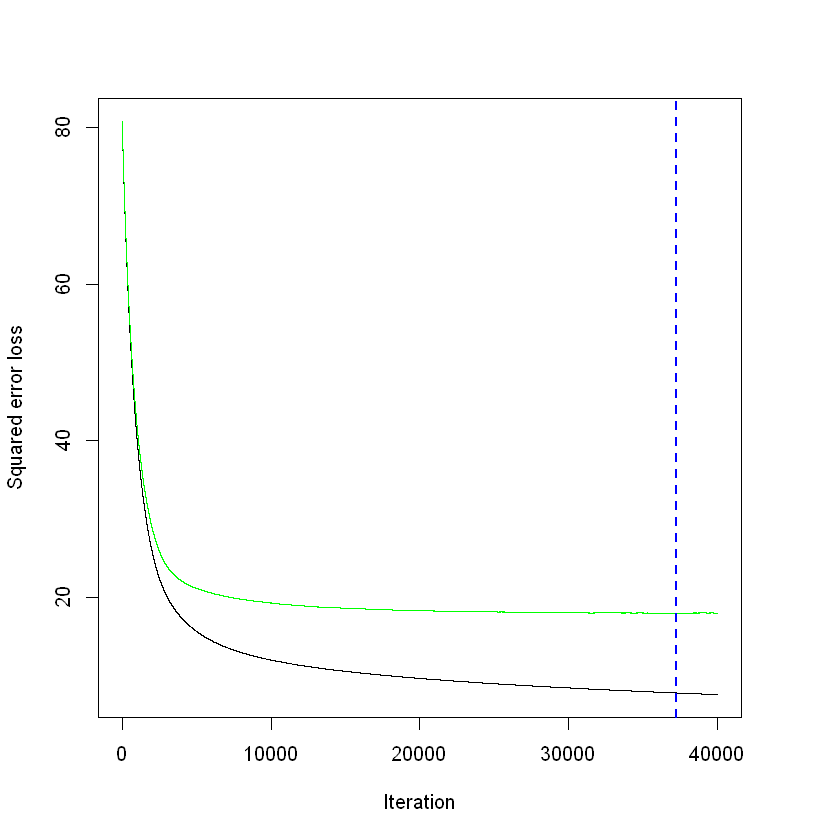

In [58]:
(best_tier = gbm.perf(data_gbm, method = "cv"))

In [60]:
yhat_gbm <- predict(data_gbm, n.trees = best_tier, newdata = validation)
rmse(y_obs, yhat_gbm)

[1] 3.655046

### 최종 모형 선택과 테스트세트 오차 계산

지금까지 적합한 모든 검증세트 오차를 비교하면 다음과 같다.

In [61]:
data.frame(lm = rmse(y_obs, yhat_step),
          glmnet = rmse(y_obs, yhat_glmnet),
          rf = rmse(y_obs, yhat_rf),
          gbm = rmse(y_obs, yhat_gbm)) %>%
reshape2::melt(value.name = 'rmse', variable.name = 'method')

No id variables; using all as measure variables


method,rmse
lm,3.839083
glmnet,3.956797
rf,3.548442
gbm,3.655046


In [62]:
rmse(test$medv, predict(data_rf, newdata = test))

[1] 3.21131

boxplot 으로 표현해보겠습니다.

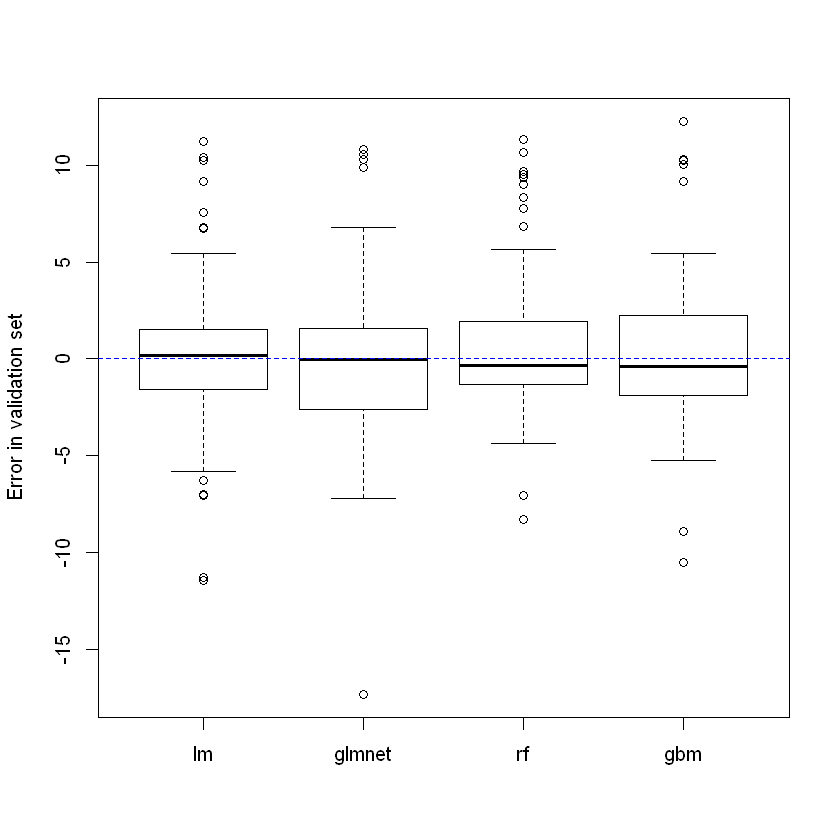

In [63]:
boxplot(list(lm = y_obs - yhat_step, 
            glmnet = y_obs - yhat_glmnet,
            rf = y_obs - yhat_rf,
            gbm = y_obs - yhat_gbm), ylab = "Error in validation set")
abline(h = 0, lty = 2, col = 'blue')

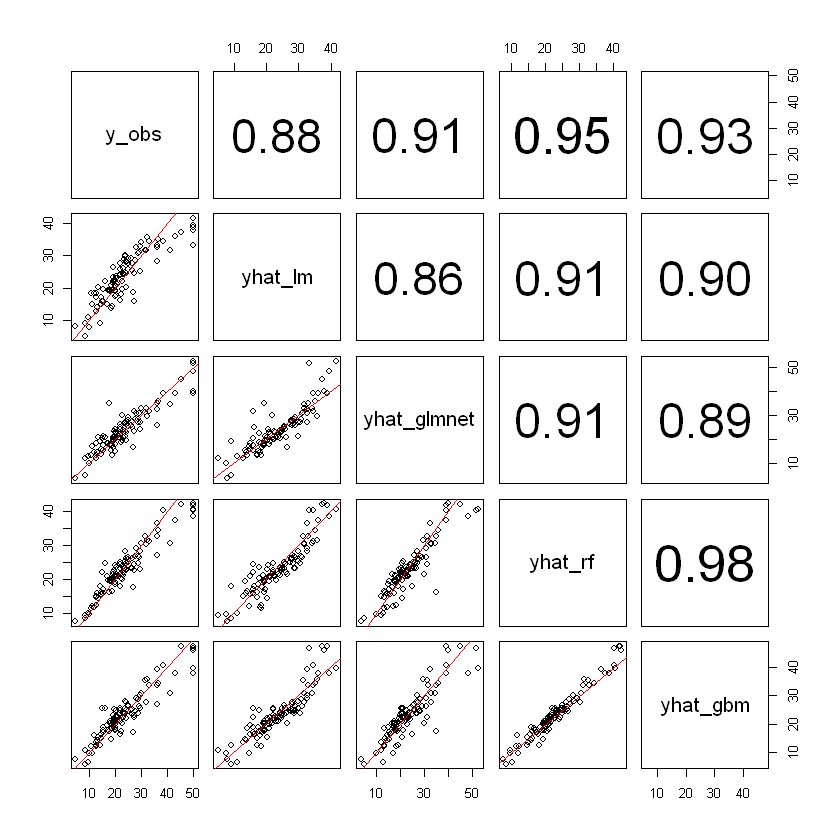

In [64]:
pairs(data.frame(y_obs = y_obs,
                yhat_lm = yhat_lm,
                yhat_glmnet = c(yhat_glmnet),
                yhat_rf = yhat_rf,
                yhat_gbm = yhat_gbm),
     lower.panel = function(x, y) { points(x, y); abline(0, 1, col = 'red') },
     upper.panel = panel.cor)